# Programmatic Access of Spectroscopic Data

In this tutorial, we add another access protocol to our tool belt: the [Table
Access Protocol](https://www.ivoa.net/documents/TAP/) (TAP). This protocol is a
Virtual-Observatory service for accessing tables via an SQL-like query language
called ADQL (Astronomical Data Query Language -
see the [CDS tutorial](http://cdsportal.u-strasbg.fr/adqltuto/)).
Many astronomical data services
are accessible via TAP, such as the ESA planetary science archive and the CDS
Vizier and Simbad databases.

TAP queries can be executed with standard graphical user interfaces such as
TOPCAT and Aladin. In this tutorial, we look once again at the programmatic
approach, using the [`pyvo`](https://pyvo.readthedocs.io/en/latest/) package.
We will access the [SSHADE](https://sshade.eu) database of laboratory spectra.

## Access of SSHADE database via TAP

The SSHADE database does not have an API to access the spectra files directly.
However, the metadata of these spectra (including, in particular, the download
URL) is accessible via TAP. We start by connecting to the service using `pyvo`.

In [1]:
import pyvo as vo

service = vo.dal.TAPService("http://osug-vo.osug.fr:8080/tap")
sshade = service.search("SELECT * FROM sshade_spectra.epn_core")  # get all entries of SSHADE metadata
sshade = sshade.to_table().to_pandas()  # convert the resulting object to a pandas DataFrame
print(f"Retrieved metadata of {len(sshade)} spectra from SSHADE")

Retrieved metadata of 6324 spectra from SSHADE


The URL of the service you want to connect to is typically given on its
website. In SSHADE's case, neither the URL nor the server response are
documented on the webpage. To prepare this tutorial, we instead got the
information by looking at how [TOPCAT](https://www.star.bris.ac.uk/~mbt/topcat/)
connects to SSHADE. Besides the URL, this
also tells us which table we have to query, which we do below. The `SELECT *
FROM ...` syntax is the aforementioned ADQL language.

<div>
  <center>
    <img src="../06-Conclusion/gfx/topcat_sshade.png" width="800"/>
  </center>
</div>

So, what did we just retrieve? Let's inspect.

In [2]:
print(sshade.columns)
sshade.head()

Index(['granule_uid', 'granule_gid', 'obs_id', 'dataproduct_type',
       'target_name', 'target_class', 'time_min', 'time_max',
       'time_sampling_step_min', 'time_sampling_step_max', 'time_exp_min',
       'time_exp_max', 'spectral_range_min', 'spectral_range_max',
       'spectral_sampling_step_min', 'spectral_sampling_step_max',
       'spectral_resolution_min', 'spectral_resolution_max', 'c1min', 'c1max',
       'c2min', 'c2max', 'c3min', 'c3max', 's_region', 'c1_resol_min',
       'c1_resol_max', 'c2_resol_min', 'c2_resol_max', 'c3_resol_min',
       'c3_resol_max', 'spatial_frame_type', 'incidence_min', 'incidence_max',
       'emergence_min', 'emergence_max', 'phase_min', 'phase_max',
       'instrument_host_name', 'instrument_name', 'measurement_type',
       'processing_level', 'creation_date', 'modification_date',
       'release_date', 'service_title', 'access_url', 'access_format',
       'access_estsize', 'access_md5', 'time_scale', 'thumbnail_url',
       'publisher',

,granule_uid,granule_gid,obs_id,dataproduct_type,target_name,target_class,time_min,time_max,time_sampling_step_min,time_sampling_step_max,...,target_distance_min,target_distance_max,azimuth_min,azimuth_max,measurement_atmosphere,pressure,temperature,species_name,species_inchikey,filter
0,SPECTRUM_DT_20170706_006,EXPERIMENT_DT_20170706_006,SPECTRUM_DT_20170706_006,sp,,sample,2457515.5,2457515.5,NaN,NaN,...,NaN,NaN,NaN,NaN,ambient air#293.0 K#100000.0 bar,NaN,293.00,,,
1,SPECTRUM_GS_20161207_001,EXPERIMENT_GS_20161207_001,SPECTRUM_GS_20161207_001,sp,,sample,2456658.5,2456658.5,NaN,NaN,...,NaN,NaN,NaN,NaN,ambient air#293.0 K#100000.0 bar,NaN,293.00,,,
2,SPECTRUM_DT_20161207_002_2,EXPERIMENT_DT_20161207_001.2,SPECTRUM_DT_20161207_002_2,sp,,sample,2453862.5,2453862.5,NaN,NaN,...,NaN,NaN,NaN,NaN,ambient air#293.15 C#100000.0 bar,500.0,293.15,,XLYOFNOQVPJJNP-UHFFFAOYSA-N,
3,SPECTRUM_DT_20161207_003_4,EXPERIMENT_DT_20161207_001.2,SPECTRUM_DT_20161207_003_4,sp,,sample,2453862.5,2453862.5,NaN,NaN,...,NaN,NaN,NaN,NaN,ambient air#293.15 C#100000.0 bar,500.0,293.15,,XLYOFNOQVPJJNP-UHFFFAOYSA-N,
4,SPECTRUM_DT_20161207_007_4,EXPERIMENT_DT_20161207_001.2,SPECTRUM_DT_20161207_007_4,sp,,sample,2453862.5,2453862.5,NaN,NaN,...,NaN,NaN,NaN,NaN,ambient air#293.15 C#100000.0 bar,500.0,293.15,,XLYOFNOQVPJJNP-UHFFFAOYSA-N,


We see a large number of metadata columns. Each column refers to one spectrum on the SSHADE platform.

Regarding the column names, some are self-explanatory, while others are more cryptic.
Most relevant for us are:

- `granule_uid` - A unique identifier for each spectra
- `granule_gid` - A unique identifier for each experiment that submitted spectra (information on the SSHADE webpage)
- `access_url` - The URL to the spectrum file itself
- `sample_classification` - Metadata of the measure sample

The SSHADE table follows the [Europlanet TAP standard](http://www.europlanet-vespa.eu/standards.shtml),
which is a pre-defined set of columns for TAP service tables. The benefit of this protocol is the uniform
connection interface to a large number of services: No matter which type of data you query, you can expect
certain columns to be present. On the other hand, as is common with standards, they can lead to odd results for
an individual service. The odd result for SSHADE is that all the metadata of the sample (arguably
the most important information) is packed into a single column called `sample_classification`. 

In [3]:
sshade['sample_classification']

0       metallic Fe#metallic solid#metal#crystalline#F...
1       metallic Ag#metallic solid#elemental solid#cry...
2       Iron ferrous solution in hydrothermal conditio...
3       Iron ferrous solution in hydrothermal conditio...
4       Iron ferrous solution in hydrothermal conditio...
                              ...                        
6319    mineral#Quartz polymorphs#Werth-Metall Juniper...
6320    mineral#Quartz polymorphs#Werth-Metall Juniper...
6321    mineral#Quartz polymorphs#Werth-Metall Juniper...
6322    mineral#Quartz polymorphs#Werth-Metall Juniper...
6323    mineral#Quartz polymorphs#Werth-Metall Juniper...
Name: sample_classification, Length: 6324, dtype: object

We therefore cannot simply get all spectra of a given meteorite class or mineral, as we would have to parse
the `sample_classification` column. Unfortunately, the content in this column does not appear to follow a certain
pattern, making it difficult to programmatically identify all spectra of interest.

Instead, in this tutorial, we will look at the spectra published in Beck+ 2021. We can select them
from the `sshade` table by looking up the required `granule_gid` on the
[SSHADE website of the experiment](https://www.sshade.eu/data/EXPERIMENT_LB_20200902_001).

In [4]:
beck21 = sshade[sshade['granule_gid'] == "EXPERIMENT_LB_20200902_001"]

We can now download the spectra using the `requests` library. The format is `VOTable`,
which we can open with the `astropy` package. As in tutorial `3.1`, we use the
`io.BytesIO` function as neat trick to avoid storing the spectra on file and to instead
open them directly. In general, it makes sense to store them to avoid repeated
queries to the server.

We download the spectra by iterating over the `beck21` dataframe and using the `access_url` in each row.

In [5]:
import io

import astropy
import requests

spectra = []

# Download spectra to local machine
for _, row in beck21[:1].iterrows():
    r = requests.get(row.access_url)

    if False: # this code would write the spectra to file
        with open(f"{row.granule_uid}.votable", "w") as file:
            file.write(r.content.decode('UTF-8'))

    else:
      spec = astropy.io.votable.parse(io.BytesIO(r.content))
      spectra.append(spec)

To convert the spectra from VOTable to a `pandas` dataframe (a more comfortable representation of the data),
we use the following one-liner.

In [6]:
spectra = [spec.get_first_table().to_table().to_pandas() for spec in spectra]

Let's look at one of these spectra.

In [7]:
print(spectra[0].columns)
spectra[0].head

Index(['wavelength', 'intensity_i0e10a0', 'error_i0e10a0', 'intensity_i0e20a0',
       'error_i0e20a0', 'intensity_i0e30a0', 'error_i0e30a0'],
      dtype='object')


<bound method NDFrame.head of     wavelength  intensity_i0e10a0  error_i0e10a0  intensity_i0e20a0  \
0        400.0           0.059648       0.000704           0.054490   
1        500.0           0.071155       0.000088           0.064937   
2        600.0           0.076120       0.000050           0.070014   
3        700.0           0.077220       0.000016           0.071062   
4        800.0           0.078557       0.000015           0.072541   
5        900.0           0.078068       0.000085           0.072114   
6       1000.0           0.071369       0.001294           0.065583   
7       1100.0           0.070491       0.000765           0.066136   
8       1200.0           0.071529       0.000557           0.065190   
9       1300.0           0.071602       0.001101           0.066406   
10      1400.0           0.072249       0.000561           0.065382   
11      1500.0           0.071167       0.000363           0.065398   
12      1600.0           0.071522       0.00025

The format is rather straight-forward: We have the `wavelength` and the `intensity` observed under
different geometries: `i=0deg` and `e in {10, 20, 30}deg`. Each intensity has an associated `error`.

To finish, let's plot one of these spectra. To add the sample metadata, we use the fact that the spectra
are in the same order as the `beck21` dataframe.

[Text(0.5, 0, 'Wavelength / micron'), Text(0, 0.5, 'Intensity')]

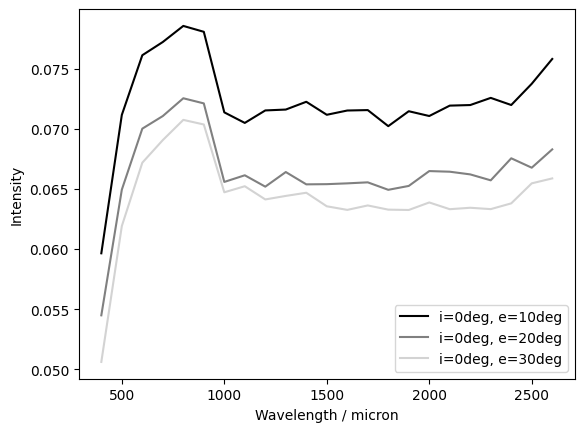

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

spec = spectra[0]  # randomly take the first spectrum

ax.plot(spec["wavelength"], spec["intensity_i0e10a0"], ls="-", label="i=0deg, e=10deg", c="black")
ax.plot(spec["wavelength"], spec["intensity_i0e20a0"], ls="-", label="i=0deg, e=20deg", c="gray")
ax.plot(spec["wavelength"], spec["intensity_i0e30a0"], ls="-", label="i=0deg, e=30deg", c="lightgray")
ax.legend()
ax.suptitle(beck21.reset_index().loc[0, 'sample_classification'])
ax.set(xlabel='Wavelength / micron', ylabel='Intensity')

At this point, our task is complete: We have programmatically accessed the
SSHADE database and retrieved spectra of our choosing. The small sidestep to
the SSHADE database to find the correct `granule_gid` of Beck+ 2021 is
unfortunate but due to the nature of the EPN TAP protocol.

How could we improve this? We could envision something like the `astroquery` syntax for SSHADE: A `SSHADE` class
that you can use to query and download spectra. This would make access easier and be beneficial for many people
if it made its way into the `astroquery` package at some point. We build this class in the advanced tutorial.